In [1]:
cd /home/disk2/wdd/PDZ/12concentration

/home/disk2/wdd/PDZ/12concentration


In [2]:
from msmbuilder.dataset import dataset
from msmbuilder.cluster import KCenters
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.cluster import MiniBatchKMedoids
from msmbuilder.msm import MarkovStateModel
from msmbuilder.lumping import PCCAPlus
from msmbuilder.lumping import PCCA
from msmbuilder.msm import implied_timescales
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
font_path = '/home/disk2/wdd/msm/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=20)

/software/anaconda2/envs/msmb/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/software/anaconda2/envs/msmb/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [36]:
import mdtraj as md
#for nt in [1]:
all_dist=[]
for nt in [1,2,3,4,5,6,7,8,10,11,12]:
    t_con=md.load('fit'+str(nt)+'.xtc',top='begin.pdb',stride=10)
    for i in range(1,13):
        pdz_ca=[atom.index for atom in t_con.topology.chain(i).atoms if ((atom.residue.index > (109+6*i) and atom.residue.index <= (114+6*i)) and (atom.name in ['CA']))]
        chain_ca=[atom.index for atom in t_con.topology.chain(0).atoms if (atom.name in ['CA'])]
        atom_pairs=[]
        for cc in chain_ca:
            for pc in pdz_ca:
                atom_pairs.append([cc,pc])       
        distances=md.compute_distances(t_con,atom_pairs=atom_pairs)
        #distances_ave=np.mean(distances,axis=1)
        outname='fit'+str(nt)+'_pdz'+str(i)+'.cs'
        wf=open(outname,'w')
        for dist in distances:
            for di in dist:
                wf.write(str(di)+'    ')
            wf.write('\n')
        wf.close()
        all_dist.append(distances)

In [38]:
all_dist_arr=np.array(all_dist)

In [22]:
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=10, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = scaled_diheds.fit_with(tica_model)
tica_trajs = scaled_diheds.transform_with(tica_model, 'ticas2/', fmt='dir-npy')

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 71, 72, 73, 74, 75, 76, 77, 78, 79]

In [40]:
from msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_dists = scaler.fit_transform(all_dist_arr)

In [48]:
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=100, n_components=5)
# fit and transform can be done in seperate steps:
tica_model.fit(scaled_dists)
tica_trajs = tica_model.transform(scaled_dists)

In [53]:
clusterer = MiniBatchKMedoids(n_clusters=600, random_state=42)

In [54]:
clustered_trajs = clusterer.fit_transform(tica_trajs)

In [55]:
lag_times = np.arange(1,700,10)
n_timescales = 20
msm_timescales = implied_timescales(clustered_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(verbose=False), n_jobs = 3)

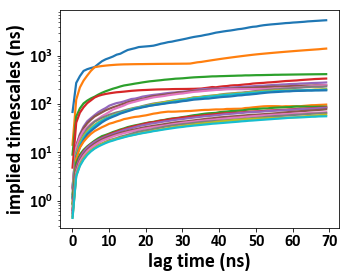

In [56]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
for i in range(n_timescales):
    plt.plot(lag_times*0.1, msm_timescales[:,i]*0.1,lw=2.2)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'lag time (ns)',fontproperties=font_prop)
plt.ylabel(r'implied timescales (ns)',fontproperties=font_prop)
#plt.xlim(-1,50)
#plt.ylim(1,1000)
plt.semilogy()
plt.savefig('impliedtimescales_tica5_lag100_kmedoids600_dihed.png',dpi=600,bbox_inches='tight')
plt.show()

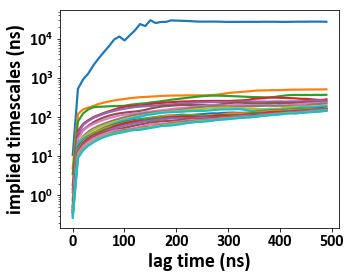

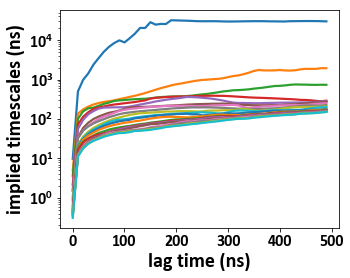

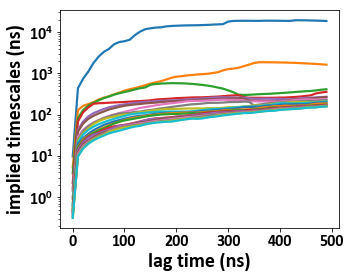

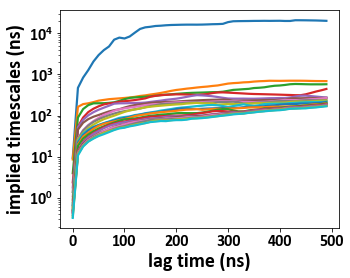

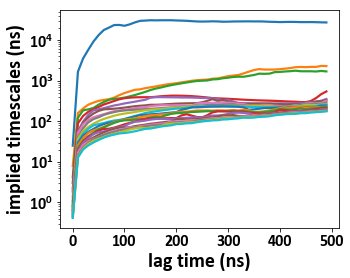

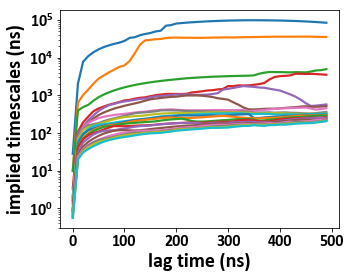

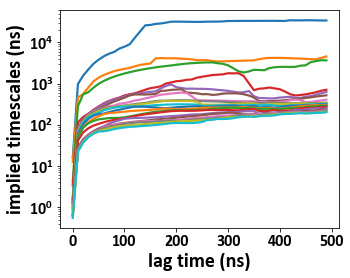

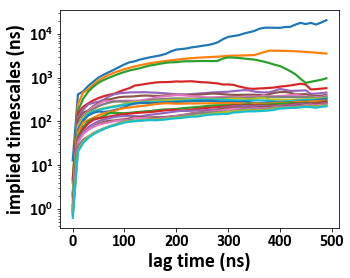

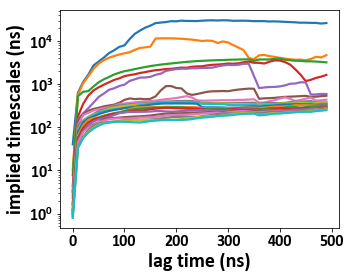

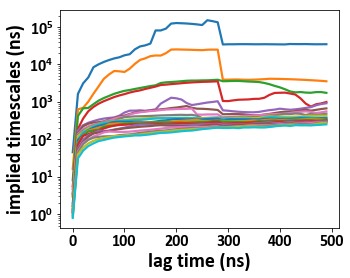

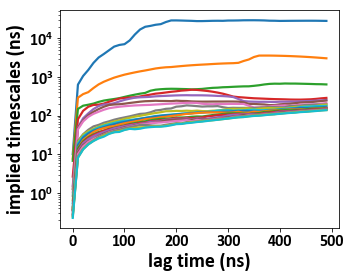

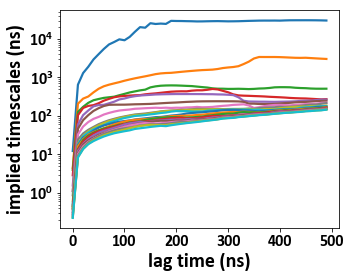

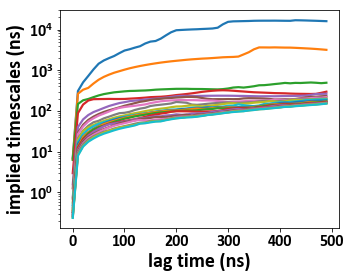

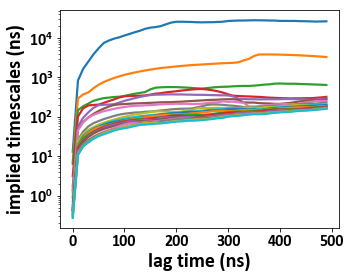

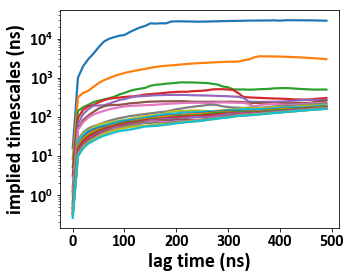

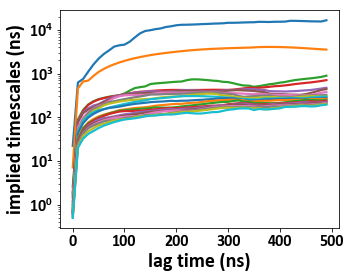

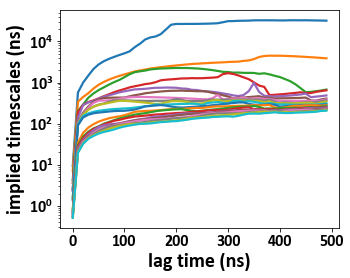

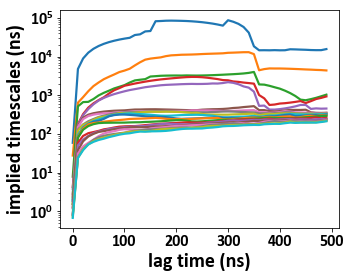

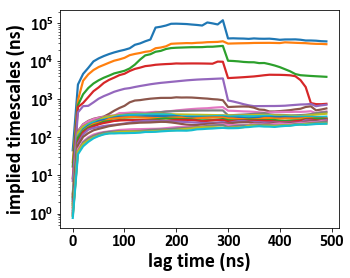

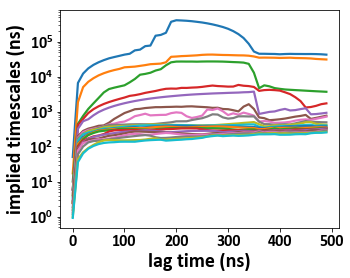

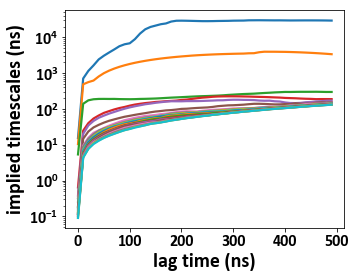

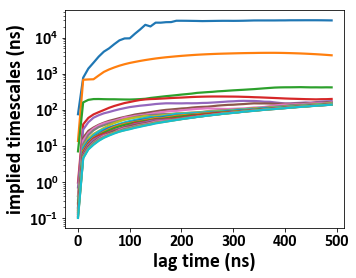

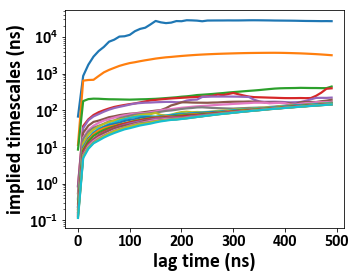

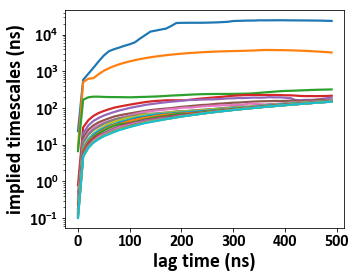

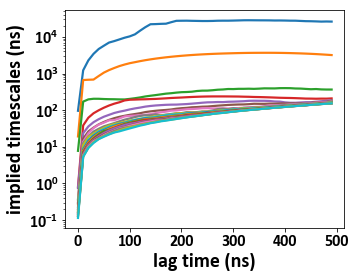

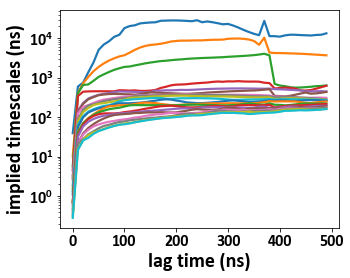

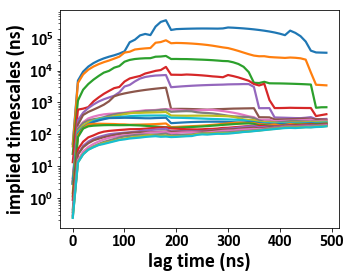

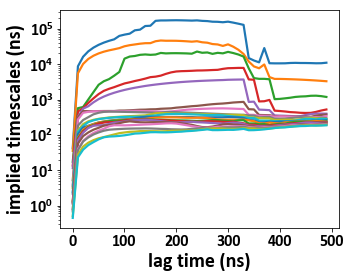

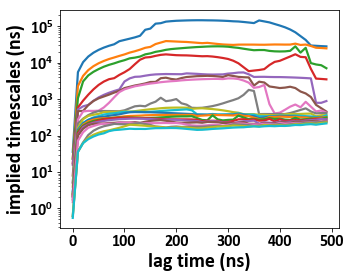

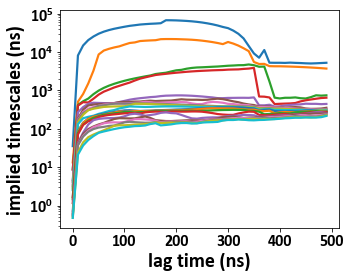

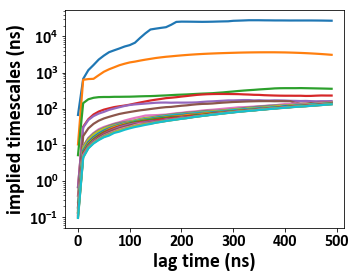

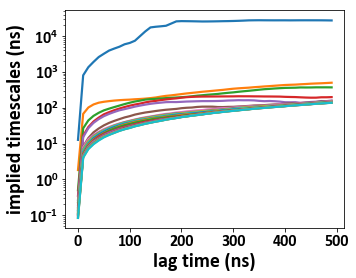

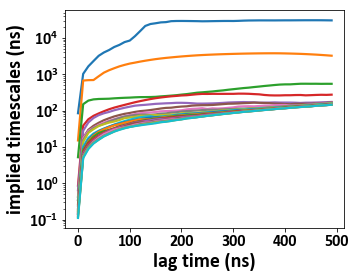

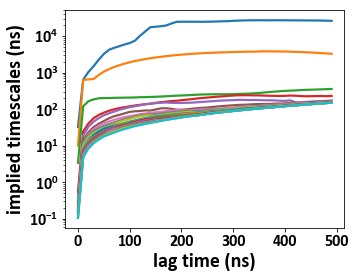

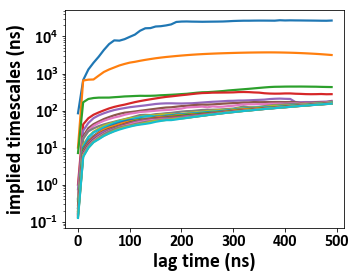

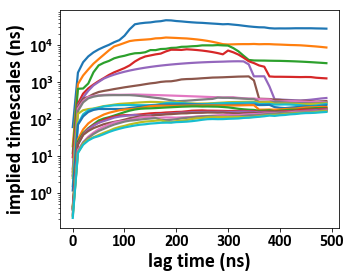

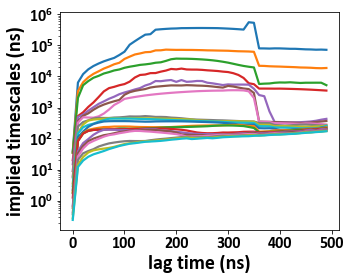

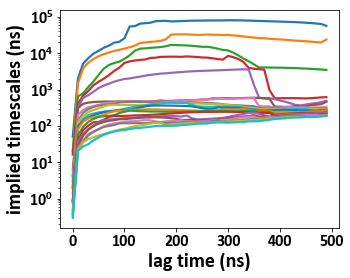

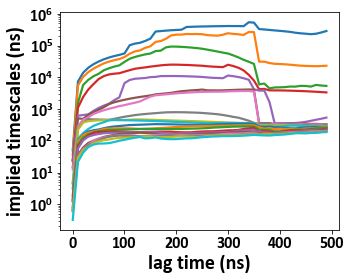

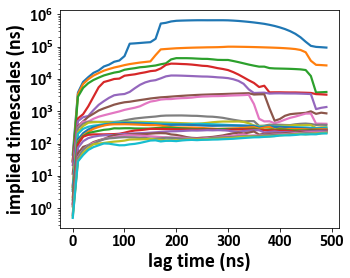

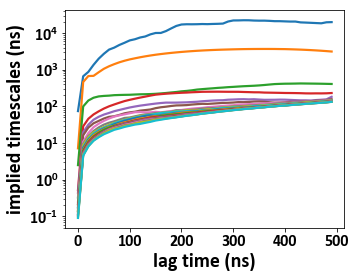

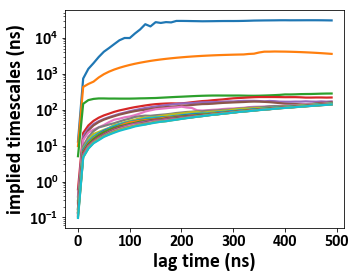

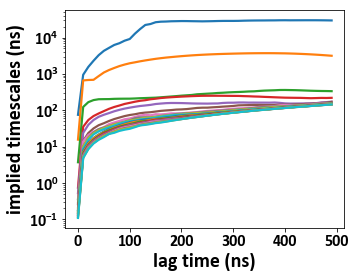

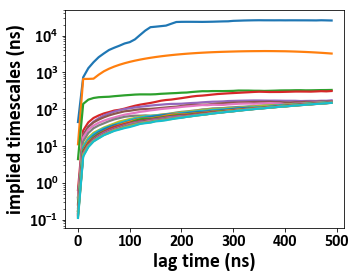

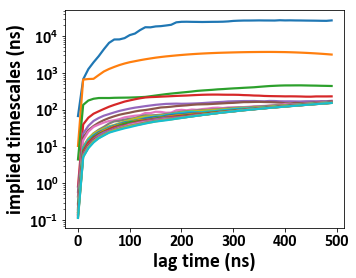

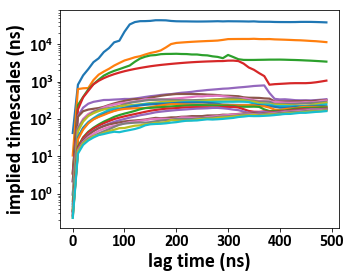

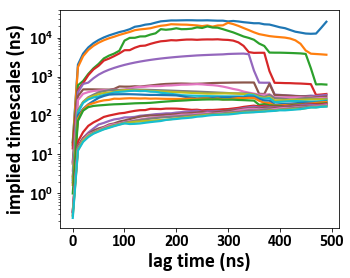

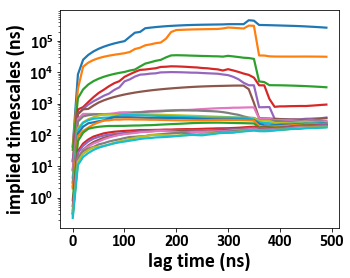

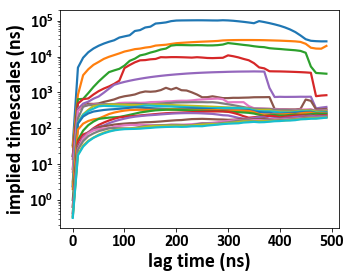

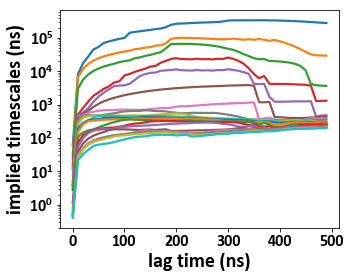

In [60]:
from msmbuilder.decomposition import tICA
#tica_lag=[50,100,200,500,800]
tica_lag=[50,100,500,800,1000]
num_components=[3,10]
num_clusters=[300,400,500,600,700]
for tlag in tica_lag:
    for ncom in num_components:
        #tica_model = tICA(lag_time=tlag, n_components=ncom,kinetic_mapping=True)
        tica_model = tICA(lag_time=tlag, n_components=ncom)
        #tica_dir='ticas_lag'+str(tlag)+'ncom'+str(ncom)+'/'
        #tica_model = scaled_diheds.fit_with(tica_model)
        tica_model.fit(scaled_dists)
        tica_trajs = tica_model.transform(scaled_dists)
        #tica_trajs = scaled_diheds.transform_with(tica_model, tica_dir, fmt='dir-npy')
        for nc in num_clusters:
            clusterer = MiniBatchKMedoids(n_clusters=nc, random_state=42)
            #cluster_dir='kmedoids'+str(tlag)+'ncom'+str(ncom)+'c'+str(nc)+'/'
            #clustered_trajs = tica_trajs.fit_transform_with(clusterer, cluster_dir, fmt='dir-npy')
            clustered_trajs = clusterer.fit_transform(tica_trajs)
            lag_times = np.arange(1,5000,100)
            n_timescales = 20
            msm_timescales = implied_timescales(clustered_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(verbose=False), n_jobs = 5)
            fig = plt.figure(figsize=(5,4))
            sub = fig.add_subplot(1,1,1)
            for i in range(n_timescales):
                plt.plot(lag_times*0.1, msm_timescales[:,i]*0.1,lw=2.2)
            for label in (sub.get_xticklabels() + sub.get_yticklabels()):
                label.set_fontproperties(font_prop)
                label.set_fontsize(16)
            plt.xlabel(r'lag time (ns)',fontproperties=font_prop)
            plt.ylabel(r'implied timescales (ns)',fontproperties=font_prop)
            #plt.ylim(1,10000)
            plt.semilogy()
            pngname='impliedtimescales_kmedoids'+str(tlag)+'ncom'+str(ncom)+'c'+str(nc)
            plt.savefig(pngname,dpi=600,bbox_inches='tight')
            plt.show()

In [61]:
import MDAnalysis
import MDAnalysis.analysis.hbonds

In [66]:
#for nt in [1,2,3,4,5,6,7,8,10,11,12]:
for nt in [2]:
    #t_con=md.load('fit'+str(nt)+'.xtc',top='begin.pdb',stride=10)
    xtc='fit'+str(nt)+'_skip10.xtc'
    u = MDAnalysis.Universe('begin.pdb', xtc)
    for i in range(1,2):
        chainname=chr(65+i)
        print chainname
        outfile = 'fit'+str(nt)+'_pdz_chain_'+chainname+'_hbonds_as_time.hb'
        h = MDAnalysis.analysis.hbonds.HydrogenBondAnalysis(u, selection1='segid A',selection2='segid '+chainname, distance=3.5, angle=150.0,distance_type='heavy')
        wf = open(outfile,'w')
        h.run()
        h.generate_table()
        for i in range(len(h.table)):
            for j in range(len(h.table[i])):
                wf.write(str(h.table[i][j])+"       ")
            wf.write("\n")
        wf.close()

B


HBonds frame 10000: 10001/10001 [100.0%]


In [65]:
pwd

u'/home/disk2/wdd/PDZ/12concentration'